In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving heart (1).csv to heart (1).csv


In [ ]:
file_name = next(iter(uploaded))
print("Loaded file:", file_name)

df = pd.read_csv(io.BytesIO(uploaded[file_name]))

print("\nFirst 5 rows of data:")
print(df.head())

print("\nColumns in dataset:")
print(df.columns)


Loaded file: heart (1).csv

First 5 rows of data:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

Columns in dataset:
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


In [ ]:
target_column = 'target'

if target_column not in df.columns:
    raise ValueError(f"'{target_column}' column not found in dataset. "
                     "Please change 'target_column' variable to your label name.")

X = df.drop(columns=[target_column])
y = df[target_column]

print("\nFeature shape:", X.shape)
print("Target shape:", y.shape)



Feature shape: (1025, 13)
Target shape: (1025,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
base_stump = DecisionTreeClassifier(
    max_depth=1,
    random_state=42
)

ada_model = AdaBoostClassifier(
    estimator=base_stump,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

ada_model.fit(X_train, y_train)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   learning_rate=0.1, n_estimators=100, random_state=42)

In [ ]:
y_pred = ada_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\n=== AdaBoost Evaluation on Test Data ===")
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



=== AdaBoost Evaluation on Test Data ===
Accuracy: 0.8780487804878049

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       100
           1       0.86      0.90      0.88       105

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205



Confusion Matrix:
[[85 15]
 [10 95]]


Text(0, 0.5, 'True label')

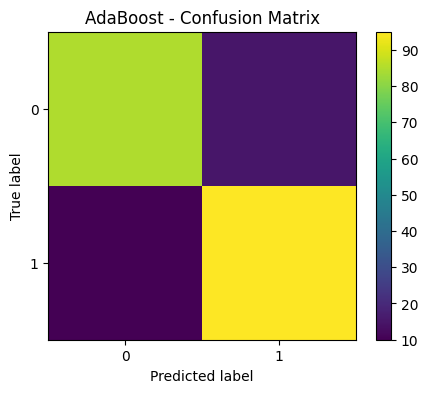

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest')
plt.title("AdaBoost - Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel('Predicted label')
plt.ylabel('True label')

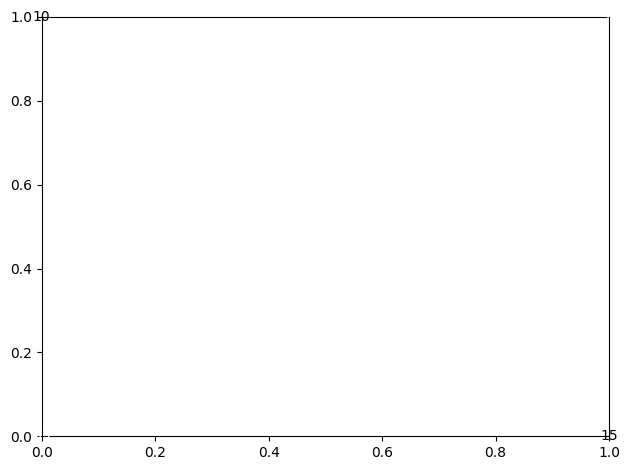

In [ ]:
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


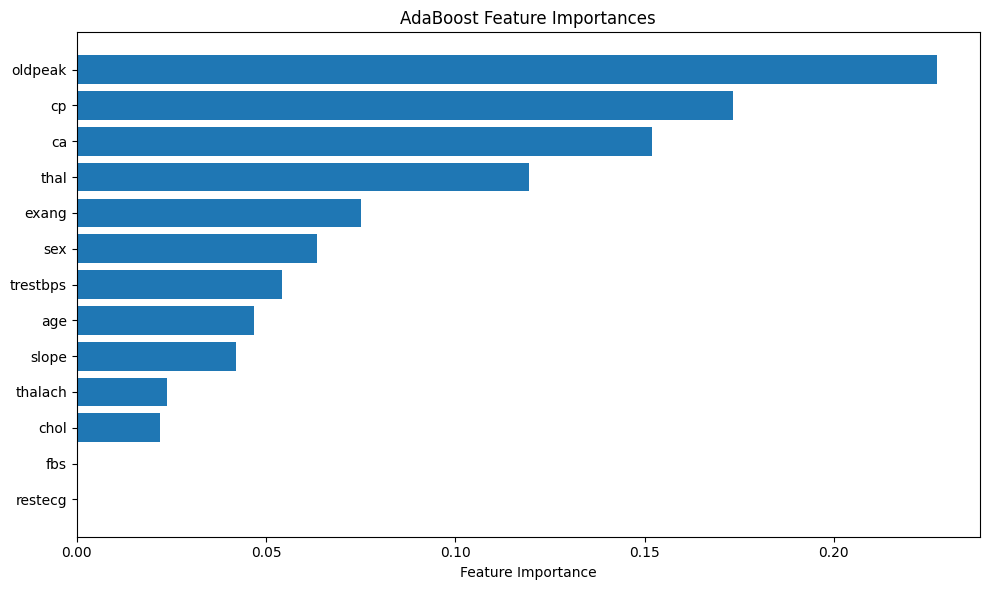

In [ ]:
importances = ada_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel("Feature Importance")
plt.title("AdaBoost Feature Importances")
plt.tight_layout()
plt.show()

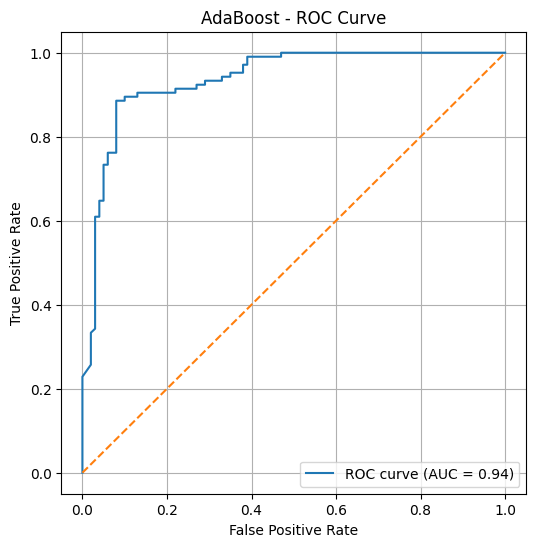

In [ ]:
if len(np.unique(y)) == 2:
    # assume larger class value is positive class
    pos_label = np.max(np.unique(y))
    y_proba = ada_model.predict_proba(X_test)[:, list(ada_model.classes_).index(pos_label)]

    fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AdaBoost - ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print("\nROC curve not plotted because this is not a binary classification problem.")

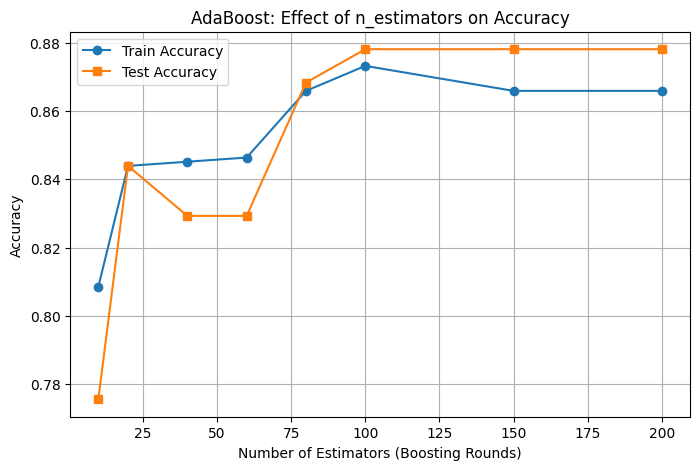

In [ ]:
n_list = [10, 20, 40, 60, 80, 100, 150, 200]
train_scores = []
test_scores = []

for n in n_list:
    temp_model = AdaBoostClassifier(
        estimator=base_stump,
        n_estimators=n,
        learning_rate=0.1,
        random_state=42
    )
    temp_model.fit(X_train, y_train)
    train_scores.append(temp_model.score(X_train, y_train))
    test_scores.append(temp_model.score(X_test, y_test))

plt.figure(figsize=(8, 5))
plt.plot(n_list, train_scores, marker='o', label='Train Accuracy')
plt.plot(n_list, test_scores, marker='s', label='Test Accuracy')
plt.xlabel("Number of Estimators (Boosting Rounds)")
plt.ylabel("Accuracy")
plt.title("AdaBoost: Effect of n_estimators on Accuracy")
plt.legend()
plt.grid(True)
plt.show()